Sedang memuat gambar...


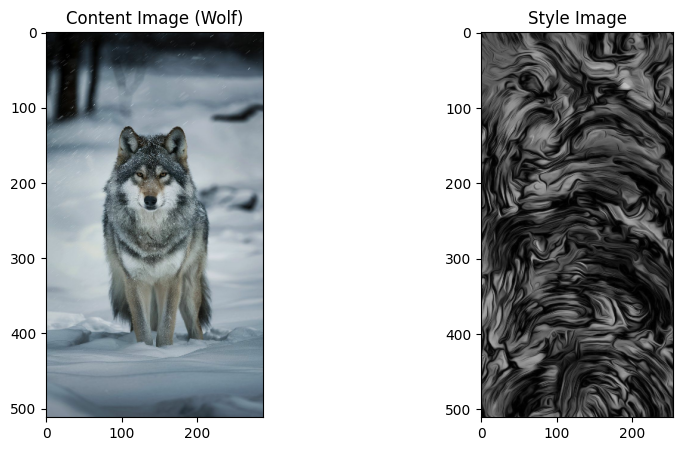

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Mulai proses Style Transfer...
....................................................................................................
Epoch: 1/10


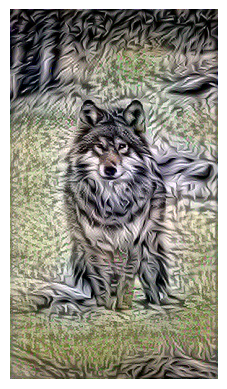

....................................................................................................
Epoch: 2/10


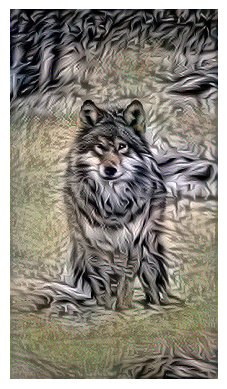

....................................................................................................
Epoch: 3/10


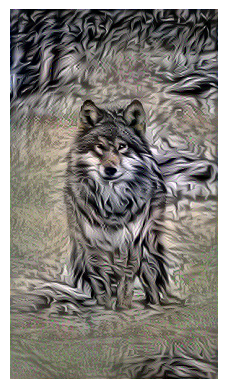

....................................................................................................
Epoch: 4/10


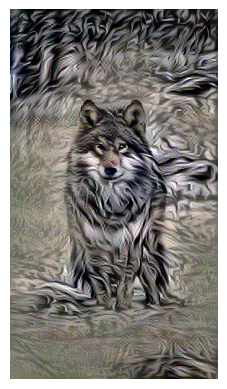

....................................................................................................
Epoch: 5/10


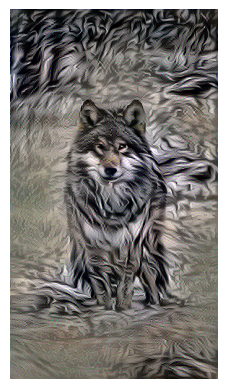

....................................................................................................
Epoch: 6/10


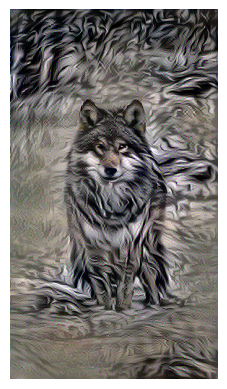

....................................................................................................
Epoch: 7/10


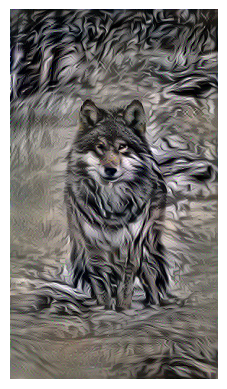

....................................................................................................
Epoch: 8/10


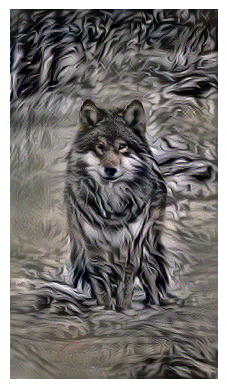

....................................................................................................
Epoch: 9/10


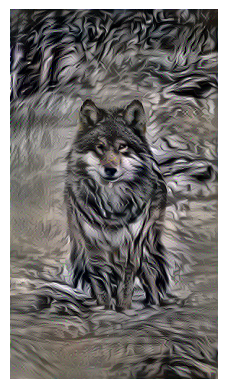

....................................................................................................
Epoch: 10/10


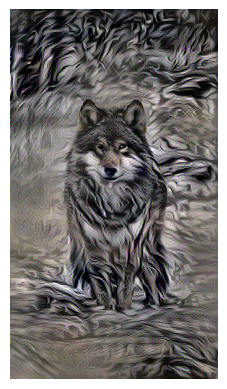

Total waktu: 57.9 detik
Gambar hasil telah disimpan di: /content/drive/MyDrive/Deep Learning Lanjut/Dataset/Tugas 1/Final results.jpg


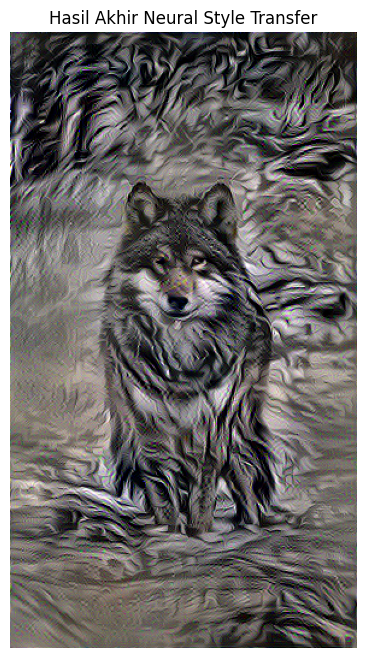

In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Input Dataset
# drive.mount('/content/drive')
content_path = '/content/drive/MyDrive/Deep Learning Lanjut/Dataset/Tugas 1/Wolf.jpg'
style_path = '/content/drive/MyDrive/Deep Learning Lanjut/Dataset/Tugas 1/ᴘɪɴᴛᴇʀᴇsᴛ _ ʙᴀsɪᴄɢɪʀʟʟ.jpg'

# FUNGSI UTILITAS (Load & Preprocessing)

def tensor_to_image(tensor):
    """Mengubah tensor menjadi gambar yang bisa ditampilkan"""
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    """Memuat gambar dan mengubah ukurannya maksimal 512px"""
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    """Menampilkan gambar menggunakan Matplotlib"""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# MEMUAT GAMBAR
print("Sedang memuat gambar...")
try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image (Wolf)')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image')
    plt.show()
except Exception as e:
    print(f"Error memuat gambar. Pastikan path benar dan Drive sudah ter-mount.\nDetail: {e}")
    # Stop eksekusi jika gambar gagal dimuat
    raise e

# MODEL VGG19 & LOSS FUNCTION
# menggunakan VGG19 pre-trained tanpa head klasifikasi
def vgg_layers(layer_names):
    """ Membuat model VGG19 yang mengembalikan output dari layer perantara """
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Layer untuk Style (tekstur/pola)
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Layer untuk Content (bentuk objek)
content_layers = ['block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def gram_matrix(input_tensor):
    """ Menghitung Gram Matrix untuk representasi style """
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:num_style_layers],
                                          outputs[num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# Inisialisasi Model
extractor = StyleContentModel(style_layers, content_layers)

# Target Style dan Content
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# TRAINING (OPTIMISASI GAMBAR)
# Gambar awal adalah gambar content yang akan diubah
image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Bobot Loss (Bisa diatur untuk mengubah keseimbangan style vs content)
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Loop Training
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

print("Mulai proses Style Transfer...")

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)

    # Tampilkan progres setiap epoch
    print(f"\nEpoch: {n+1}/{epochs}")
    plt.imshow(tensor_to_image(image))
    plt.axis('off')
    plt.show()

end = time.time()
print(f"Total waktu: {end-start:.1f} detik")

# SIMPAN HASIL
result_image = tensor_to_image(image)
output_path = '/content/drive/MyDrive/Deep Learning Lanjut/Dataset/Tugas 1/Final results.jpg'
result_image.save(output_path)

print(f"Gambar hasil telah disimpan di: {output_path}")
plt.figure(figsize=(8, 8))
plt.imshow(result_image)
plt.title("Hasil Akhir Neural Style Transfer")
plt.axis('off')
plt.show()